<a href="https://colab.research.google.com/github/shengweihuang/Signature-classification/blob/main/Dex_data_classification_using_signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dex data classification using signature**
#### **Shengwei Huang**

## **Introduction**
The interpretation and management of streamed data has become an important area of research for the computer science, database, and statistics communities. Signature as data transform maps multi-dimensional paths to the sequence of their iterated integrals.
\
We treat signatures as features in this method. Then, we use the binary classifier to distinguish different time intervals. This is the first step towards the signature trading strategies.

# **Signature**
#### **Definition**
For a path $X: [a,b] \to \mathbb{R^d}$, recall that we denote the coordinate paths by $(X^1_t,...X^d_t)$, where each $X^i:[a,b]\to\mathbb{R}$ is a real-valued path. For any singla index $i∈${$1,...,d$}, let us define thequantity\
$S(X)^i_{a,t} =  \int_{a<s<t}  \,dX^i_s = X^i_t-X^i_0,$\
\
Now for any pair $i,j∈${$1,...,d$}, let us define the *double-iterated integral*
$S(X)^{i,j}_{a,t} =  \int_{a<s<t}S(X)^i_{a,s}  \,dX^j_s =\int_{a<r<s<t}\,dX^i_rdX^j_s ,$\
\
The real numbr $S(X)^{i_1,...,i_k}_{a,t}$ is called the k-fold iterated integral of X along indexes $i_1,...,i_k$: $S(X)^{i_1,...,i_k}_{a,t} = \int_{a<t_k<t}...∫_{a<t_1<t_2}dX^{i_1}_{t_1}...dX^{i_k}_{t_k}$\
\
**Definition** (Signature). The *signature* of a path $X:[a,b]\to \mathbb{R}^d,$ denoted by $S(X)_{a,b}$, is the collection (infinite series) of all the iterated integrals of $X$. Fromally, $S(X)_{a,b}$ is the sequence of real numbers
$S(X)_{a,b} = (1,S(X)^1_{a,b},...,S(X)^d_{a,b},S(X)^{1,1}_{a,b},S(X)^{1,2}_{a,b},...)$

\
#### **Properties**
- **Invariance under Time Reparametrisations**\
The signature of a path (a record of its movements) remains the same regardless of how we stretch or compress the time axis.
- **Shuffle Product**\
The shuffle product is a way to combine the signatures of two different paths in a systematic manner.
- **Chen’s Identity**\
Chen's identity is a mathematical equation that relates the signature of a path to its iterated integrals. It's a fundamental equation in the theory of signatures
- **Time-reversal**\
Time-reversal is a property where reversing the order of a path's movements doesn't change its signature.
- **Log Signature**\
The log signature is a way to transform a signature into a more manageable format. It's useful for simplifying calculations involving signatures.
- **Uniqueness**\
The uniqueness property means that every path has a unique signature associated with it. No two distinct paths should have the same signature.

# **Application**
We explore to what extent the signatures of 30-minute data streams determine the time bucket they are sampled from. In particular, we run binary classification on various pairs of time intervals, and explore which time buckets show similar behaviour and which time buckets have unique characteristics.
## **Data**
We used Uniswap v3 WETH/USDC(0.05%) pool on Mainnet from 2021/5/5 to 2022/9/24.
## **Setting**
**a. The method contains the following steps:**
1. Normalsized the time, normalized logarithm of mid-price, trading volume, and cumulative trading volume in order to hide the obvious features.
2. We performed data resampling to aggregate the information at 30-minute intervals.
3. In order to capture the quadratic variation of the log-price, the lead transformation is computed and is paired with the log-transform of log-price.
4. We compute the signature of each stream up to depth 4.
5. We explore to what extent the signatures of 8-hour data streams determine the time bucket they are sampled from.

**b. Linear regression-based classification**
We use linear regression combined with LASSO shrinkage:
1. The model's hyperparameters were determined through a k-fold cross-validation approach, utilizing 5-fold validation.
2. 75 percent of the streams in each category are used as a learning set, and the remaining streams are used for out-of-sample testing.
3. The value of the dependent variable(response) is defined to be 0 along the streams of one category and 1 along the streams of the other category.

**c. Statistical indicators**

1. The Kolmogorov-Smirnov distance of the distributions of regressed values
2. We plot the receiver operating characteristic (ROC) curve and compute the area under the ROC curve for the regressed values calculated using the learning set of streams.
3. We repeat using the score values computed using the out-of-sample streams.

## **Code**
#### **Data input**


In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title
pip install iisignature

In [ ]:
# @title
import os
import pandas as pd
import datetime
import iisignature
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from itertools import combinations
from decimal import Decimal
from scipy.stats import ks_2samp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
def split_into_intervals(dataframe):
    global start_date  # Add this line to use the global variable inside the function
    intervals = {}
    for interval_num in range(3):
        # Get the start and end times for the current interval
        interval_start = start_date + pd.Timedelta(minutes=480 * interval_num)
        interval_end = interval_start + pd.Timedelta(minutes = 480)

        # Filter the dataframe to get data within the current interval
        interval_data = dataframe[(dataframe['time'] >= interval_start) & (dataframe['time'] < interval_end)]

        # Save the interval_data into intervals dictionary with interval_num as the key
        intervals[interval_num] = interval_data
    return intervals





In [ ]:
USDCWETH005 = pd.read_csv("/content/drive/MyDrive/Signature/USDCWETH (0.05%).csv")
USDCWETH005.iloc[:, 0] = pd.to_datetime(USDCWETH005.iloc[:, 0], unit ='s')
USDCWETH005.set_index('timestamp', inplace=True)
print(USDCWETH005)

                     Unnamed: 0       ordinal       amount0       amount1  \
timestamp                                                                   
2021-05-05 22:15:01           0  123768910073 -1.197441e+08  3.500000e+16   
2021-05-05 23:37:55           1  123772780240  4.997564e+08 -1.442411e+17   
2021-05-05 23:51:36           2  123773450133  3.650000e+08 -1.034924e+17   
2021-05-05 23:56:34           3  123773640353 -1.761808e+08  5.000000e+16   
2021-05-05 23:57:36           4  123773690133 -5.142800e+08  1.460000e+17   
...                         ...           ...           ...           ...   
2022-09-24 23:58:47      302809  156066530100 -1.018257e+09  7.731750e+17   
2022-09-24 23:58:47      302810  156066530211 -6.716577e+08  5.100000e+17   
2022-09-24 23:59:23      302811  156066560261 -2.197807e+09  1.668840e+18   
2022-09-24 23:59:35      302812  156066570182 -3.154662e+08  2.395415e+17   
2022-09-24 23:59:59      302813  156066590142 -1.010000e+08  7.669196e+16   

Define the components:
- $P:price\  (USDC/WETH)$,
- $V:number\ of\ traded\ value$,
- $C: cumulative\ traded\ volume$.




#### **Resampling and Normalizing**
We need time ($t_i$), price($P_{ti}$), and amout of USD($V$) to calculate our inputs.\
We performed data resampling to aggregate the information at 30-minute intervals.\
We define the components:
* the *normalized time*: $ u_{ti} := \frac{t_i - t_0}{t_N-t_0},$
* the *normalized logarithm of mid-price*: $p_{ti} := C_plog P_{ti},$\
where for each stream, $C_p$ is chosen to satisfy $StDev(\Delta p) = 1,$

* the *normalized imbalance*: $d_{ti}:=V$
* the *normalized cumulative volume*: $c_{ti}:=\frac{C_{ti}}
{C_{tN}}$

In [ ]:
price = USDCWETH005['price(token0/token1)'].resample('30T').last()
price = price.fillna(method='ffill') #NaN的部分轉換為0
price = price.astype(int)
time = pd.Series((price.index))
price.reset_index(drop= True, inplace = True)
amount = USDCWETH005['amount0'].resample('30T').sum().abs()
amount = amount.fillna(0)
amount.reset_index(drop= True, inplace = True)

input = pd.DataFrame()
input['time'] = time
input['ETH_Price'] = price
input['ETH_Amount'] = amount
start_date = pd.to_datetime('2021-05-05 00:00')
end_date = pd.to_datetime('2022-09-24 23:59')
date_range = pd.date_range(start=start_date, end=end_date, freq='30T')
num_days = (end_date - start_date).days+1
WB = pd.DataFrame({'time': date_range})
input = pd.merge(WB, input, on='time', how='left')
input.fillna(0, inplace=True)

combined_dict = {}
for i in range(num_days):
    intervals = split_into_intervals(input)

    for key in intervals.keys():
        if key in combined_dict:
            combined_dict[key] = pd.concat([combined_dict[key], intervals[key]], ignore_index=True)
        else:
            combined_dict[key] = intervals[key]
    start_date = start_date + pd.Timedelta(days = 1)

for key, df in combined_dict.items():
    step = 1 / 16
    normalized_time = pd.Series([((i+1) % 16)/16 for i in range(len(df))])
    df['Ntime'] = normalized_time
    df.loc[df['Ntime'] == 0, 'Ntime'] = 1
min_std_threshold = 1e-10
for key,df in combined_dict.items():
    ETH_price_change = combined_dict[key]['ETH_Price'].diff()
    combined_dict[key]['ETH_Nlog_mid_price'] = 0
    for i in range(num_days):
        ETH_subset = ETH_price_change.iloc[i*16:(i+1)*16]
        ETH_std_price_change = ETH_subset.std()

        if ETH_std_price_change <= min_std_threshold:
            ETH_Nlog= np.zeros_like(ETH_subset)
        else:
            Cp = 1 / ETH_std_price_change
            ETH_Nlog = (Cp * np.log(combined_dict[key]['ETH_Price'].iloc[i*16:(i+1)*16]))

        ETH_Nlog[ETH_Nlog == -np.inf] = 0
        combined_dict[key]['ETH_Nlog_mid_price'].iloc[i*16:(i+1)*16] = ETH_Nlog
for key,df in combined_dict.items():
    combined_dict[key]['ETH_Nimbalance'] = 0
    combined_dict[key]['ETH_Ncumulative_volume'] = 0
    for i in range(508):
        ETH_amount = combined_dict[key]['ETH_Amount'].iloc[i*16:(i+1)*16].cumsum()
        total = sum(combined_dict[key]['ETH_Amount'].iloc[i*16:(i+1)*16])
        eth_ncumulative_volume = ETH_amount/total
        eth_ncumulative_volume[eth_ncumulative_volume.isna()] = 0
        combined_dict[key]['ETH_Ncumulative_volume'].iloc[i*16:(i+1)*16]  = eth_ncumulative_volume
        combined_dict[key]['ETH_Nimbalance'] = combined_dict[key]['ETH_Amount']

#### **Lead-lag Transformation**

In particular, given a stream $\left( \widehat{X_{ti}}\right)^N_{i=0}$ in $\mathbb{R}^d$, we define its lead-transformed stream $\left ( \widehat{X}^{lead}_{ti}\right)^{2N}_{j=0}$ by\

  $ \widehat{X}^{lead}_j\begin{cases}
        \widehat{X}_{ti}\;if j = 2i \\
        \widehat{X}_{ti}\;if j = 2i-1
    \end{cases}
  $\
  \
  Moreover, we define its lag-transformed stream $\left ( \widehat{X}^{lag}_{ti}\right)^{2N}_{j=0}$ by\
  $ \widehat{X}^{lag}_j\begin{cases}
        \widehat{X}_{ti}\;if j = 2i \\
        \widehat{X}_{ti}\;if j = 2i+1
    \end{cases}
  $\
  \
Example:
$X:(0,1,2,3,4,5)$\
$X^{lead}:(0,1,1,2,2,3,3,4,4,5,5)$\
$X^{lag}:(0,0,1,1,2,2,3,3,4,4,5)$



\
We define $\widehat{X} := \left(u_{ti},p_{ti},d_{ti},c_{ti} \right)^N_{i=0}$.\
  In order to capture the quadratic variation of the log-price, the lead-transform $\widehat{X}^{lead}$ is computed and is paired with the lag-transform of $p$; hence, the input streams are of theform:\
$\left( \widehat{Z}_{j} \right)^{2N}_{j=0}:=\left(u^{lead}_{j},p^{lead}_{j},d^{lead}_{j},c^{lead}_{j}, p^{lag}_{j} \right)^{2N}_{j=0}$

\
#### **Signature Calculating**
We compute the signature of each stream up to depth 4, that is for all iterated integrals that are indexed with multi-indices of length at most 4. The signatures are computed with the **iisignature** Python package.

In [ ]:
def calculate_signature(df):
    # Reshape the DataFrame to split it into groups of 6 rows
    num_groups = len(df) // 16
    df_groups = [df.iloc[i * 16 : (i + 1) * 16] for i in range(num_groups)]

    # Calculate the signature for each group and store the results in a list
    signatures = {}
    count = 0
    for group in df_groups:

        input_signature = pd.DataFrame()
        Ntime_lead = group['Ntime'].repeat(2)[1:].reset_index(drop = True)
        ETH_Nlog_mid_price_lead = group['ETH_Nlog_mid_price'].repeat(2)[1:].reset_index(drop = True)
        ETH_Nimbalance_lead = group['ETH_Nimbalance'].repeat(2)[1:].reset_index(drop = True)
        ETH_Ncumulative_volume_lead = group['ETH_Ncumulative_volume'].repeat(2)[1:].reset_index(drop = True)
        ETH_Nlog_mid_price_lag = group['ETH_Nlog_mid_price'].repeat(2)[:-1].reset_index(drop = True)
        input_signature['Ntime_lead'] = Ntime_lead
        input_signature['ETH_Nlog_mid_price_lead'] = ETH_Nlog_mid_price_lead
        input_signature['ETH_Nimbalance_lead'] = ETH_Nimbalance_lead
        input_signature['ETH_Ncumulative_volume_lead'] = ETH_Ncumulative_volume_lead
        input_signature['ETH_Nlog_mid_price_lag'] = ETH_Nlog_mid_price_lag
        data_for_signature = input_signature.values

        signature = iisignature.sig(data_for_signature, 4)
        signatures[count] = signature
        count +=1


    return signatures

In [ ]:
signatures = {}
# Loop through each DataFrame in the dictionary and calculate the signatures
for key, df in combined_dict.items():
    signatures[key] = calculate_signature(df)

#### **LASSO Regression-based Classification**
This is how we labeling the Signature series, we take all the Signature series in the first time interval as label 0, and the second time intercal as label 1.\
\
$S_1 \to 0$\
$S_2 \to 0$\
....\
$S_{509} \to 1$\
$S_{510} \to 1$\
....\
\
Then we used the LASSO for classification:

$\min\limits_{β} \left[ \sum\limits_{k=1}^K \left( \sum\limits_{I∈{I_m}}β_IZ^I_{0,2N_K}(k)-y(k) \right)^2+α∑\limits_{I∈I_m}|β_I|\right],$\
\
where $I_m$ denotes the set of multi-indices of length at most m, $β=(β_I)_{I∈I_m}$, $K$ denotes the cardinality of the learning set, $Z(k)$ denotes the axis path corresponding to the $k$th input stream $(\widehat{Z_i})^{2N_k}_{i=0}(k)$, $y(k)$ denotes the category (0 or 1) of the $k$th input stream, and $α$ is the shrinkage parameter. For each test case, the level of $α$ is determined by k-fold cross-validation.\
We used the **scikit-learn** Python package to compute the LASSO-based regression coefficients.

#### **Code of LASSO regression-based classification**

In [ ]:
# @title
selected_labels = [0,1]
flat_dict = {}
for label in selected_labels:
    for sub_key, array in signatures[label].items():
        if label == selected_labels[0]:
            flat_dict[(0, sub_key)] = array
        else:
            flat_dict[(1, sub_key)] = array

feature_matrix = []
target_vector = []
for (label, sub_key), array in flat_dict.items():
    feature_matrix.append(array)
    target_vector.append(label)
feature_matrix = np.array(feature_matrix)
target_vector = np.array(target_vector)

'''
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

alpha_values = np.logspace(-6, 2, 100)

best_alpha01 = None
best_accuracy = 0.0



for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha)

    accuracies = []

    for train_index, val_index in kf.split(feature_matrix):
        feature_train, feature_val = feature_matrix[train_index], feature_matrix[val_index]
        target_train, target_val = target_vector[train_index], target_vector[val_index]

        lasso_model.fit(feature_train, target_train)

        val_regressed_values = lasso_model.predict(feature_val)
        val_pred_binary = (val_regressed_values > 0.5).astype(int)

        val_accuracy = accuracy_score(target_val, val_pred_binary)
        accuracies.append(val_accuracy)

    avg_accuracy = np.mean(accuracies)

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_alpha01 = alpha

'''



train_size = 0.75
feature_train01, feature_test01, target_train01, target_test01 = train_test_split(feature_matrix, target_vector, train_size=train_size, random_state=42)

lasso_model01 = Lasso(alpha = 4.977023564332114e-05)
lasso_model01.fit(feature_train01, target_train01)




In [ ]:
# @title
selected_labels = [0,2]
flat_dict = {}
for label in selected_labels:
    for sub_key, array in signatures[label].items():
        if label == selected_labels[0]:
            flat_dict[(0, sub_key)] = array
        else:
            flat_dict[(1, sub_key)] = array

feature_matrix = []
target_vector = []
for (label, sub_key), array in flat_dict.items():
    feature_matrix.append(array)
    target_vector.append(label)
feature_matrix = np.array(feature_matrix)
target_vector = np.array(target_vector)

'''
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

alpha_values = np.logspace(-6, 2, 100)

best_alpha02 = None
best_accuracy = 0.0



for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha)

    accuracies = []

    for train_index, val_index in kf.split(feature_matrix):
        feature_train, feature_val = feature_matrix[train_index], feature_matrix[val_index]
        target_train, target_val = target_vector[train_index], target_vector[val_index]

        lasso_model.fit(feature_train, target_train)

        val_regressed_values = lasso_model.predict(feature_val)
        val_pred_binary = (val_regressed_values > 0.5).astype(int)

        val_accuracy = accuracy_score(target_val, val_pred_binary)
        accuracies.append(val_accuracy)

    avg_accuracy = np.mean(accuracies)

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_alpha02 = alpha
'''




train_size = 0.75
feature_train02, feature_test02, target_train02, target_test02 = train_test_split(feature_matrix, target_vector, train_size=train_size, random_state=42)

lasso_model02 = Lasso(alpha = 3.4304692863149194e-05)
lasso_model02.fit(feature_train02, target_train02)


train_regressed_values02 = lasso_model02.predict(feature_train02)


test_regressed_values02 = lasso_model02.predict(feature_test02)

train_pred_binary02 = (train_regressed_values02 > 0.5).astype(int)
test_pred_binary02 = (test_regressed_values02 > 0.5).astype(int)

train_accuracy02 = accuracy_score(target_train02, train_pred_binary02)
test_accuracy02 = accuracy_score(target_test02, test_pred_binary02)
print(train_accuracy02)
print(test_accuracy02)

In [ ]:
# @title
selected_labels = [1,2]
flat_dict = {}
for label in selected_labels:
    for sub_key, array in signatures[label].items():
        if label == selected_labels[0]:
            flat_dict[(0, sub_key)] = array
        else:
            flat_dict[(1, sub_key)] = array

feature_matrix = []
target_vector = []
for (label, sub_key), array in flat_dict.items():
    feature_matrix.append(array)
    target_vector.append(label)
feature_matrix = np.array(feature_matrix)
target_vector = np.array(target_vector)

'''
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

alpha_values = np.logspace(-6, 2, 100)

best_alpha12 = None
best_accuracy = 0.0



for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha)

    accuracies = []

    for train_index, val_index in kf.split(feature_matrix):
        feature_train, feature_val = feature_matrix[train_index], feature_matrix[val_index]
        target_train, target_val = target_vector[train_index], target_vector[val_index]

        lasso_model.fit(feature_train, target_train)

        val_regressed_values = lasso_model.predict(feature_val)
        val_pred_binary = (val_regressed_values > 0.5).astype(int)

        val_accuracy = accuracy_score(target_val, val_pred_binary)
        accuracies.append(val_accuracy)

    avg_accuracy = np.mean(accuracies)

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_alpha12 = alpha

'''



train_size = 0.75
feature_train12, feature_test12, target_train12, target_test12 = train_test_split(feature_matrix, target_vector, train_size=train_size, random_state=42)

lasso_model12 = Lasso(alpha = 39.44206059437664)
lasso_model12.fit(feature_train12, target_train12)


train_regressed_values12 = lasso_model12.predict(feature_train12)


test_regressed_values12 = lasso_model12.predict(feature_test12)

train_pred_binary12 = (train_regressed_values12 > 0.5).astype(int)
test_pred_binary12 = (test_regressed_values12 > 0.5).astype(int)

train_accuracy12 = accuracy_score(target_train12, train_pred_binary12)
test_accuracy12 = accuracy_score(target_test12, test_pred_binary12)
print(train_accuracy12)
print(test_accuracy12)

# **Numerical Tests**
Despite hiding the obvious features, the 00:00-08:00 versus 08:00-16:00 UTC time buckets show very distinctive characteristics.

We present the classification results in Figures 1, 2, and 3. (the estimated densities of regressed values and the ROC curve)

Table 1 contains some more results. Apart from the Kolmogorov-Smirnov distance, area under the ROC curve and the ratio of correct classification, the table shows the number of relevant variables identified by the LASSO shrinkage algorithm. In particular, the most relevant terms of fourth-order iterated integrals, such as the ones that correspond to these multi-indices:\
(5, 3, 2, 1), (3, 2, 2, 1), (5, 2, 3, 1), and (5, 3, 5, 1),

where 1, 2, 3, and 5 are the indices of normalized time(lead), normalized logarithm of mid-price(lead), trading volume(lead), and normalized logarithm of mid-price(lag).


| buckets        | KS distance of LS | KS distance of OS | Area under ROC curve of LS | Area under ROC curve of OS | Ratio of correct classification of LS | Ratio of correct classification of OS |
|----------------|-------------------|-------------------|----------------------------|----------------------------|---------------------------------------|---------------------------------------|
| 00-08 vs 08-16 | 0.559             | 0.402             | 0.865                      | 0.718                      | 0.778                                 | 0.681                                 |
| 00-08 vs 16-24 | 0.493             | 0.290             | 0.833                      | 0.635                      | 0.747                                 | 0.583                                 |
| 08-16 vs 16-24 | 0.461             | 0.149             | 0.816                      | 0.567                      | 0.722                                 | 0.559                                 |

## **<center>Tabel 1: The time buckets comparison LS: learning set, OS: out-of-sample set.<center>**

#### **Code of finding the most relevant terms of fourth-order iterated integrals**

In [ ]:
def index_to_variables(index):
    variables = ['1', '2', '3', '4', '5']
    result = []

    while index > 0:
        remainder = index % len(variables)
        if remainder == 0:
            remainder = len(variables)  # Special case for the last variable
        result.insert(0, variables[remainder - 1])
        index = (index - remainder) // len(variables)

    print(tuple(result))


In [ ]:
for i, index in enumerate(top_20_indices):
    index_to_variables(index)

#### **Code of statistical indicators**

In [ ]:
# @title
train_regressed_values01 = lasso_model01.predict(feature_train01)
test_regressed_values01 = lasso_model01.predict(feature_test01)


category_0_values_train = train_regressed_values01[target_train01== 0]
category_1_values_train = train_regressed_values01[target_train01 == 1]
category_0_values_test = test_regressed_values01[target_test01 == 0]
category_1_values_test = test_regressed_values01[target_test01 == 1]


# Calculate the CDF for each category
cdf_category_0_train = np.cumsum(category_0_values_train) / np.sum(category_0_values_train)
cdf_category_1_train = np.cumsum(category_1_values_train) / np.sum(category_1_values_train)
cdf_category_0_test = np.cumsum(category_0_values_test) / np.sum(category_0_values_test)
cdf_category_1_test = np.cumsum(category_1_values_test) / np.sum(category_1_values_test)
# Calculate the KS distance between the two CDFs
ks_distance_train01, _ = ks_2samp(category_0_values_train,category_1_values_train)
ks_distance_test01, _ = ks_2samp(category_0_values_test, category_1_values_test)

#AUC
train_auc01 = roc_auc_score(target_train01, train_regressed_values01)
test_auc01 = roc_auc_score(target_test01, test_regressed_values01)

#Ratio of correct classification
train_pred_binary01 = (train_regressed_values01 > 0.5).astype(int)
test_pred_binary01 = (test_regressed_values01 > 0.5).astype(int)
train_accuracy01 = accuracy_score(target_train01, train_pred_binary01)
test_accuracy01 = accuracy_score(target_test01, test_pred_binary01)

print("Kolmogorov-Smirnov Distance of LS:", ks_distance_train01)
print("Kolmogorov-Smirnov Distance of OS:", ks_distance_test01)
print("Area under ROC curve of LS:", train_auc01)
print("Area under ROC curve of OS:", test_auc01)
print("Ratio of correct classification of LS:",train_accuracy01)
print("Ratio of correct classification of OS:",test_accuracy01)

In [ ]:
# @title
train_regressed_values02 = lasso_model02.predict(feature_train02)
test_regressed_values02 = lasso_model02.predict(feature_test02)

category_0_values_train = train_regressed_values02[target_train02 == 0]
category_1_values_train = train_regressed_values02[target_train02 == 1]
category_0_values_test = test_regressed_values02[target_test02 == 0]
category_1_values_test = test_regressed_values02[target_test02 == 1]


# Calculate the CDF for each category
cdf_category_0_train = np.cumsum(category_0_values_train) / np.sum(category_0_values_train)
cdf_category_1_train = np.cumsum(category_1_values_train) / np.sum(category_1_values_train)
cdf_category_0_test = np.cumsum(category_0_values_test) / np.sum(category_0_values_test)
cdf_category_1_test = np.cumsum(category_1_values_test) / np.sum(category_1_values_test)
# Calculate the KS distance between the two CDFs
ks_distance_train02, _ = ks_2samp(category_0_values_train,category_1_values_train)
ks_distance_test02, _ = ks_2samp(category_0_values_test, category_1_values_test)

#AUC
train_auc02 = roc_auc_score(target_train02, train_regressed_values02)
test_auc02 = roc_auc_score(target_test02, test_regressed_values02)

#Ratio of correct classification
train_pred_binary02 = (train_regressed_values02 > 0.5).astype(int)
test_pred_binary02 = (test_regressed_values02 > 0.5).astype(int)
train_accuracy02 = accuracy_score(target_train02, train_pred_binary02)
test_accuracy02 = accuracy_score(target_test02, test_pred_binary02)


print("Kolmogorov-Smirnov Distance of LS:", ks_distance_train02)
print("Kolmogorov-Smirnov Distance of OS:", ks_distance_test02)
print("Area under ROC curve of LS:", train_auc02)
print("Area under ROC curve of OS:", test_auc02)
print("Ratio of correct classification of LS:",train_accuracy02)
print("Ratio of correct classification of OS:",test_accuracy02)

In [ ]:
# @title
train_regressed_values12 = lasso_model12.predict(feature_train12)
test_regressed_values12 = lasso_model12.predict(feature_test12)

category_0_values_train = train_regressed_values12[target_train12 == 0]
category_1_values_train = train_regressed_values12[target_train12 == 1]
category_0_values_test = test_regressed_values12[target_test12 == 0]
category_1_values_test = test_regressed_values12[target_test12 == 1]


# Calculate the CDF for each category
cdf_category_0_train = np.cumsum(category_0_values_train) / np.sum(category_0_values_train)
cdf_category_1_train = np.cumsum(category_1_values_train) / np.sum(category_1_values_train)
cdf_category_0_test = np.cumsum(category_0_values_test) / np.sum(category_0_values_test)
cdf_category_1_test = np.cumsum(category_1_values_test) / np.sum(category_1_values_test)
# Calculate the KS distance between the two CDFs
ks_distance_train12, _ = ks_2samp(category_0_values_train,category_1_values_train)
ks_distance_test12, _ = ks_2samp(category_0_values_test, category_1_values_test)

#AUC
train_au12 = roc_auc_score(target_train12, train_regressed_values12)
test_auc12 = roc_auc_score(target_test12, test_regressed_values12)

#Ratio of correct classification
train_pred_binary12 = (train_regressed_values12 > 0.5).astype(int)
test_pred_binary12 = (test_regressed_values12 > 0.5).astype(int)
train_accuracy12 = accuracy_score(target_train12, train_pred_binary12)
test_accuracy12 = accuracy_score(target_test12, test_pred_binary12)

print("Kolmogorov-Smirnov Distance of LS:", ks_distance_train12)
print("Kolmogorov-Smirnov Distance of OS:", ks_distance_test12)
print("Area under ROC curve of LS:", train_auc12)
print("Area under ROC curve of OS:", test_auc12)
print("Ratio of correct classification of LS:",train_accuracy12)
print("Ratio of correct classification of OS:",test_accuracy12)

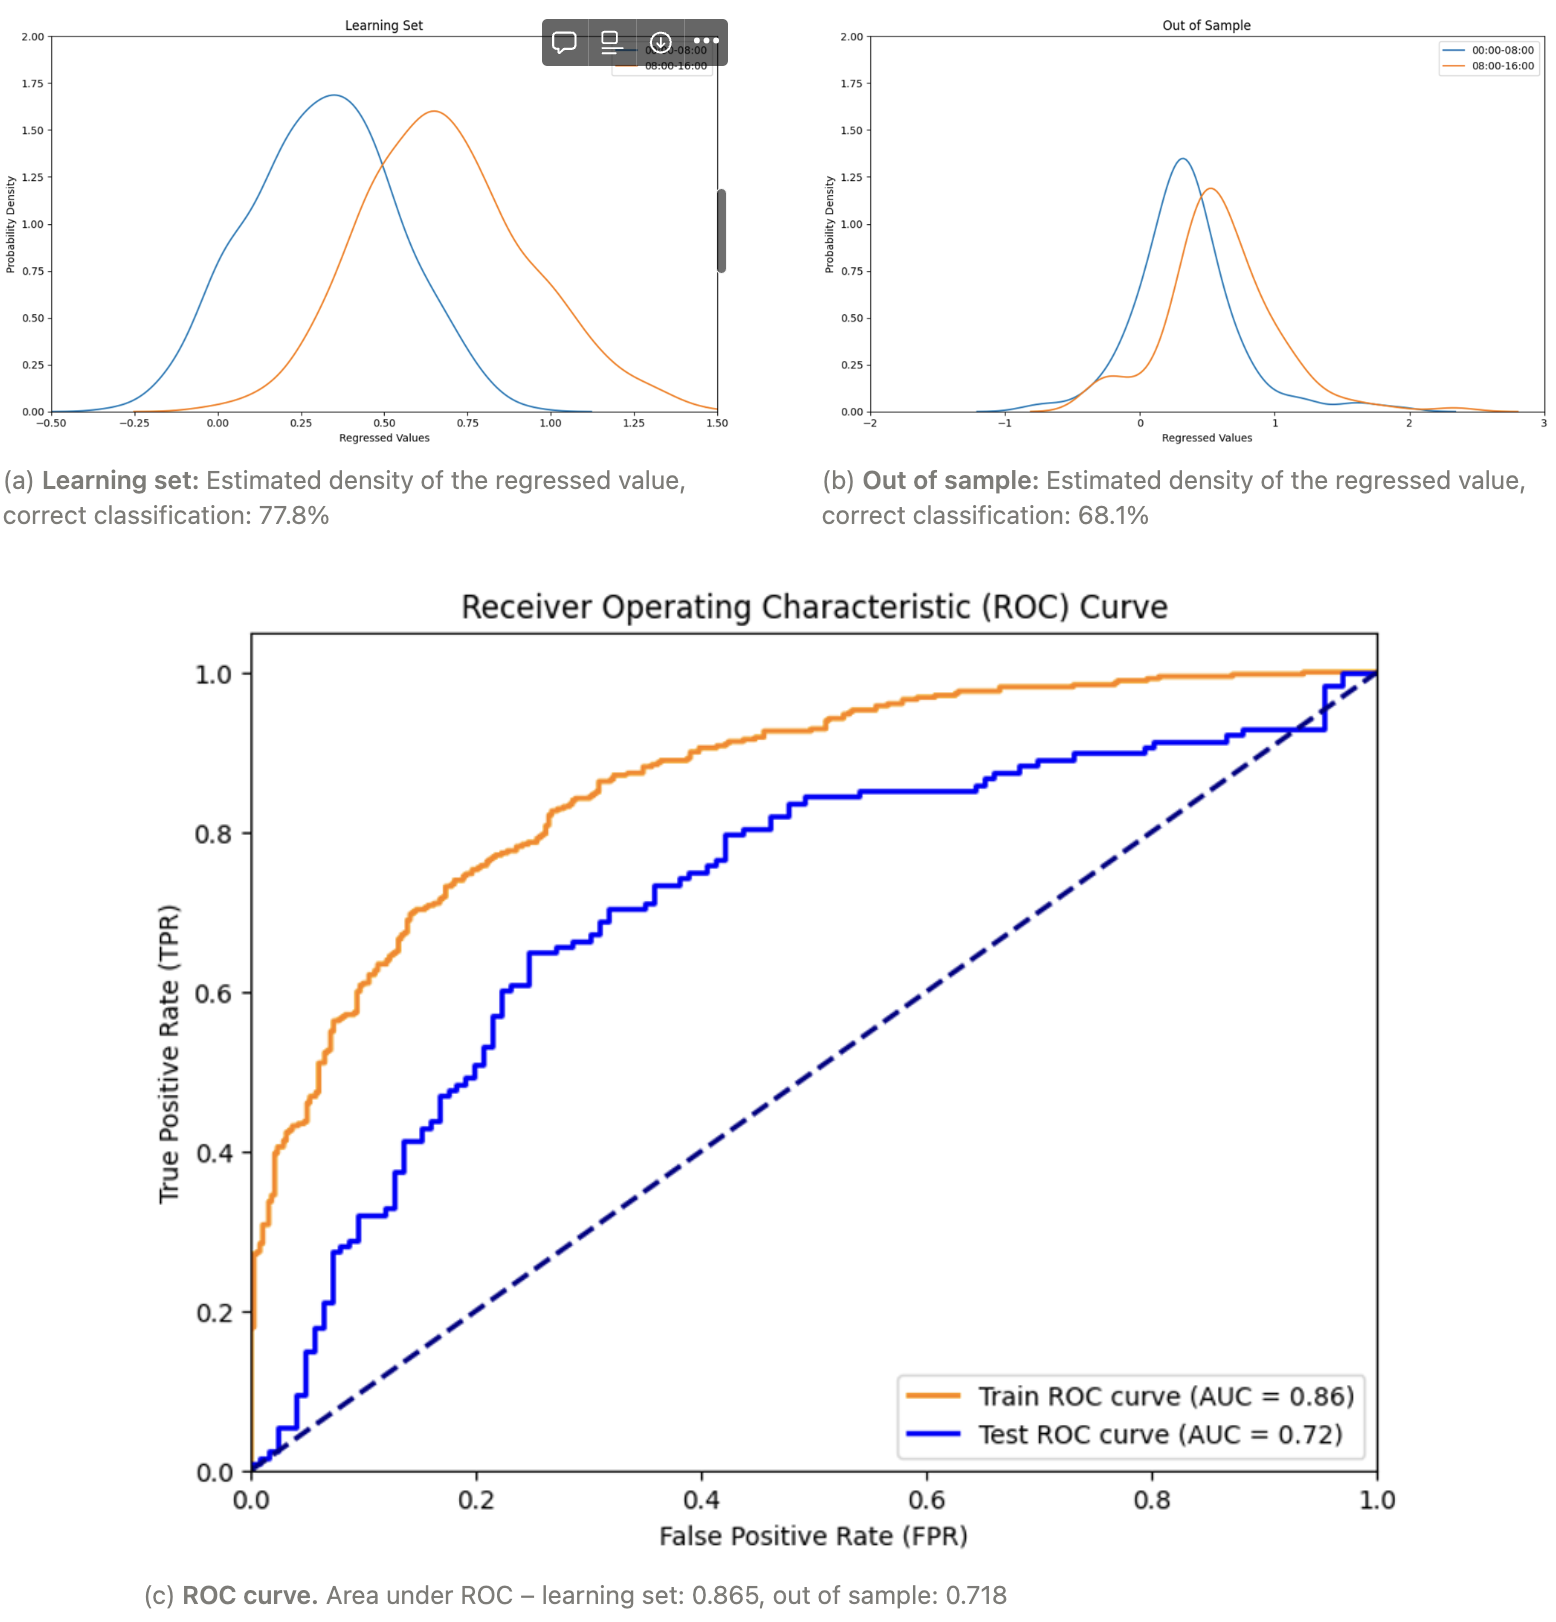

## **<center>Figure 1: 00:00-08:00 UTC versus 08:00-16:00 UTC<center>**


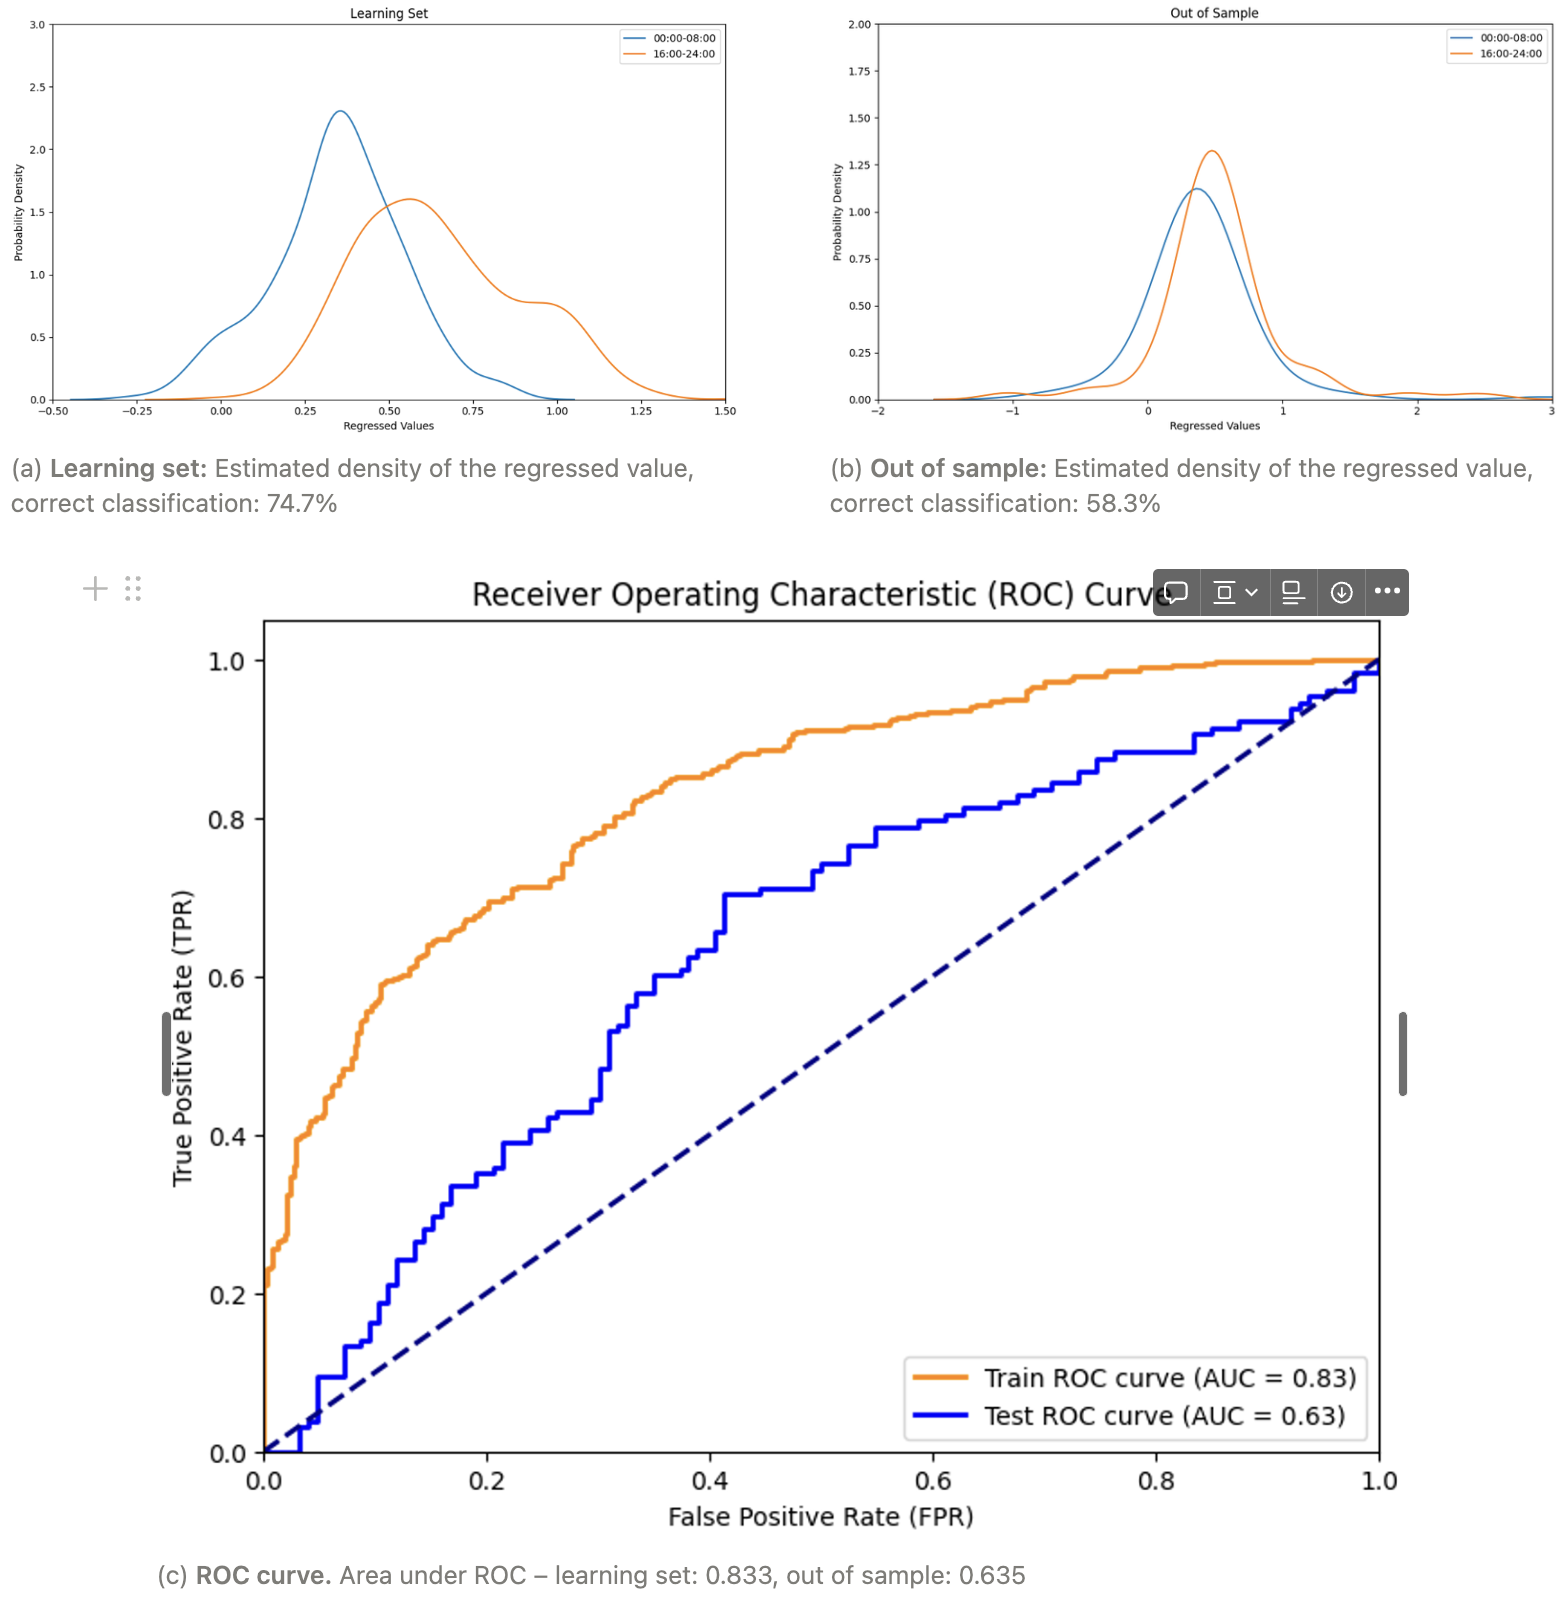

## **<center>Figure 2: 00:00-08:00 UTC versus 16:00-24:00 UTC<center>**

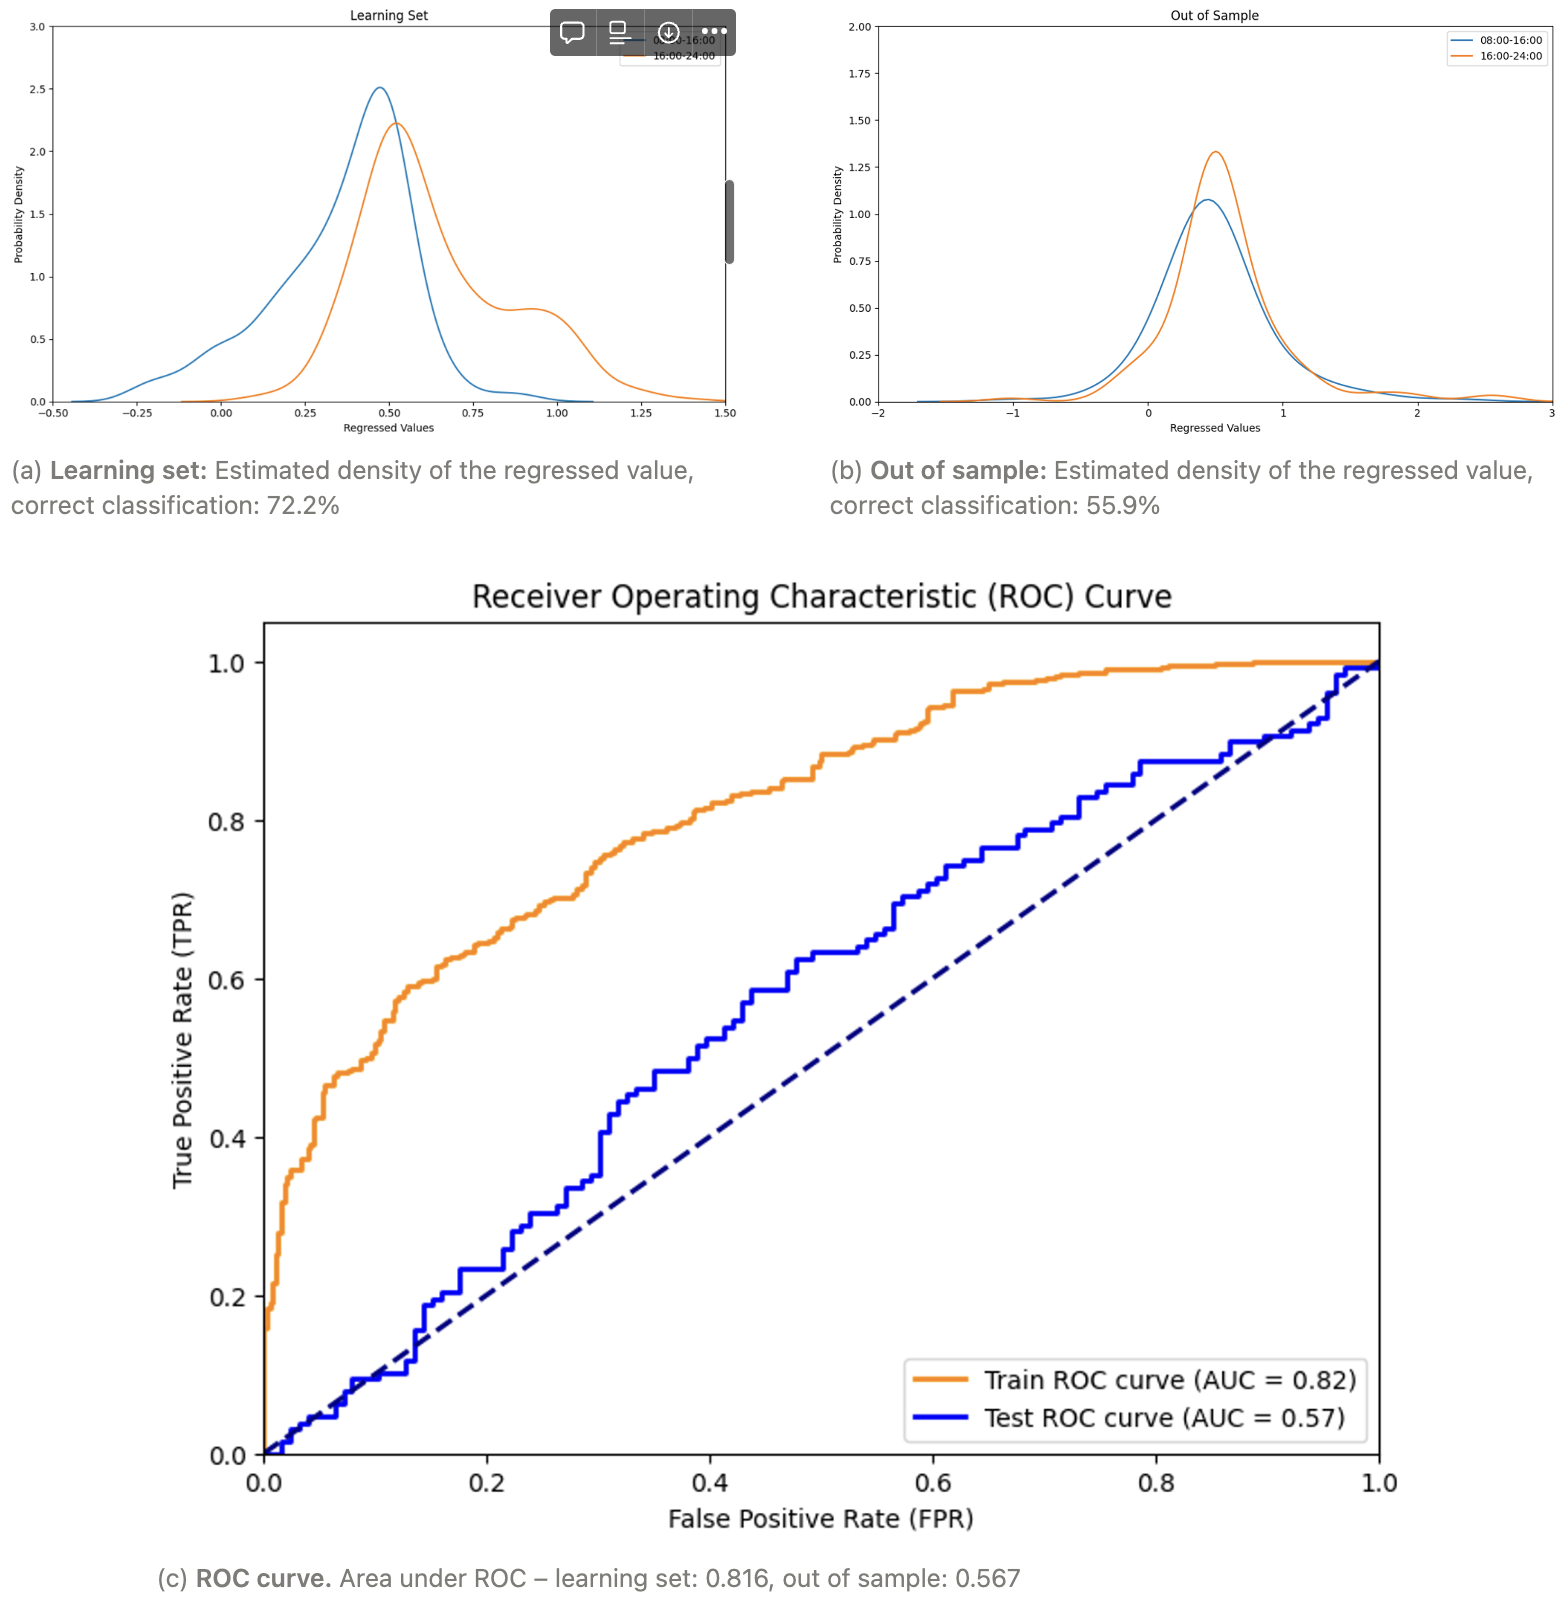

## **<center>Figure 3: 08:00-16:00 UTC versus 16:00-24:00 UTC<center>**

#### **Code of plots**

In [ ]:
# @title
# 00-08 vs 08-16
# Split the train_regressed_values and test_regressed_values based on their labels
train_regressed_values_label_0 = train_regressed_values01[target_train01 == 0]
train_regressed_values_label_1 = train_regressed_values01[target_train01 == 1]
test_regressed_values_label_0 = test_regressed_values01[target_test01 == 0]
test_regressed_values_label_1 = test_regressed_values01[target_test01 == 1]

plt.figure(figsize=(10, 6))
plt.title("Learning Set")
sns.kdeplot(train_regressed_values_label_0, label='00:00-08:00')
sns.kdeplot(train_regressed_values_label_1, label='08:00-16:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-0.5, 1.5)  # Set x-axis limits
plt.ylim(0, 2)       # Set y-axis limits
plt.tight_layout()
plt.show()

# Create KDE plots for testing set
plt.figure(figsize=(10, 6))
plt.title("Out of Sample")
sns.kdeplot(test_regressed_values_label_0, label='00:00-08:00')
sns.kdeplot(test_regressed_values_label_1, label='08:00-16:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-2, 3)  # Set x-axis limits
plt.ylim(0, 2)       # Set y-axis limits
plt.tight_layout()
plt.show()

fpr_test, tpr_test, thresholds_test = roc_curve(target_test01, test_regressed_values01)
fpr_train, tpr_train, thresholds_train = roc_curve(target_train01, train_regressed_values01)
roc_auc_test = roc_auc_score(target_test01, test_regressed_values01)
roc_auc_train = roc_auc_score(target_train01, train_regressed_values01)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# @title
# 00-08 vs 16-24
# Split the train_regressed_values and test_regressed_values based on their labels
train_regressed_values_label_0 = train_regressed_values02[target_train02 == 0]
train_regressed_values_label_1 = train_regressed_values02[target_train02 == 1]
test_regressed_values_label_0 = test_regressed_values02[target_test02 == 0]
test_regressed_values_label_1 = test_regressed_values02[target_test02 == 1]

plt.figure(figsize=(10, 6))
plt.title("Learning Set")
sns.kdeplot(train_regressed_values_label_0, label='00:00-08:00')
sns.kdeplot(train_regressed_values_label_1, label='16:00-24:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-0.5, 1.5)  # Set x-axis limits
plt.ylim(0, 3)       # Set y-axis limits
plt.tight_layout()
plt.show()

# Create KDE plots for testing set
plt.figure(figsize=(10, 6))
plt.title("Out of Sample")
sns.kdeplot(test_regressed_values_label_0, label='00:00-08:00')
sns.kdeplot(test_regressed_values_label_1, label='16:00-24:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-2, 3)  # Set x-axis limits
plt.ylim(0, 2)       # Set y-axis limits
plt.tight_layout()
plt.show()

fpr_test, tpr_test, thresholds_test = roc_curve(target_test02, test_regressed_values02)
fpr_train, tpr_train, thresholds_train = roc_curve(target_train02, train_regressed_values02)
roc_auc_test = roc_auc_score(target_test02, test_regressed_values02)
roc_auc_train = roc_auc_score(target_train02, train_regressed_values02)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# @title
#08-16 vs 16-24
# Split the train_regressed_values and test_regressed_values based on their labels
train_regressed_values_label_0 = train_regressed_values12[target_train12 == 0]
train_regressed_values_label_1 = train_regressed_values12[target_train12 == 1]
test_regressed_values_label_0 = test_regressed_values12[target_test12 == 0]
test_regressed_values_label_1 = test_regressed_values12[target_test12 == 1]

plt.figure(figsize=(10, 6))
plt.title("Learning Set")
sns.kdeplot(train_regressed_values_label_0, label='08:00-16:00')
sns.kdeplot(train_regressed_values_label_1, label='16:00-24:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-0.5, 1.5)  # Set x-axis limits
plt.ylim(0, 3)       # Set y-axis limits
plt.tight_layout()
plt.show()

# Create KDE plots for testing set
plt.figure(figsize=(10, 6))
plt.title("Out of Sample")
sns.kdeplot(test_regressed_values_label_0, label='08:00-16:00')
sns.kdeplot(test_regressed_values_label_1, label='16:00-24:00')
plt.legend()
plt.xlabel("Regressed Values")
plt.ylabel("Probability Density")
plt.xlim(-2, 3)  # Set x-axis limits
plt.ylim(0, 2)       # Set y-axis limits
plt.tight_layout()
plt.show()

fpr_test, tpr_test, thresholds_test = roc_curve(target_test12, test_regressed_values12)
fpr_train, tpr_train, thresholds_train = roc_curve(target_train12, train_regressed_values12)
roc_auc_test = roc_auc_score(target_test12, test_regressed_values12)
roc_auc_train = roc_auc_score(target_train12, train_regressed_values12)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Conclusion**
- We have observed that the classification accuracy is notably higher when distinguishing between the time intervals of 00:00-08:00 and 08:00-16:00.
- We use the terms in the signature of a data stream to define features for supervised learning algorithms.
- The numerical examples demonstrate that signature-based classification has great potential in machine learning.

# **Reference**
[1] Lajos Gergely Gyurko, Terry Lyons, Mark Kontkowski, and Jonathan Field, *Extracting information from the signature of a financial data stream,* Oxford-Man Institute of Quantitative Finance, University of Oxford, 2014

[2]Python package: scikit-learn, http://scikit-learn.org/

[3]Python package: iisignature, https://pypi.org/project/iisignature/